# Mac Miller Markov Chains
A notebook using Mac Miller's song lyrics to build a Markov chain lyric generator 
### By: David Taylor

### Using lyricsgenius library to download all of Mac Miller's song lyrics

In [ ]:
import lyricsgenius as genius
ARTIST = 'Mac Miller'

# access lyricsgenius api with client access token
with open('/Users/david/Documents/blog_source_creds/client_access_token.txt') as f:
    api = genius.Genius(f.read().strip('\n'))
artist = api.search_artist(ARTIST)
lyrics = artist.save_lyrics()

In [ ]:
import pandas as pd

# reformat lyrics into pandas df
songs = lyrics.get('songs')
lyric_list = [(song.get('title'), song.get('album'),
               song.get('lyrics')) for song in songs]
df = pd.DataFrame(lyric_list, columns=['title', 'album', 'lyrics'])

# writing lyric df to csv for reuse
file_path = '/Users/david/blog-source/mac_markov/lyrics.csv'
df.to_csv(file_path, index=False)

In [1]:
# read data back in to pandas df (useful for continuing work because API retrieval takes a while)
df = pd.read_csv('lyrics.csv')
df.head()

,title,album,lyrics
0,100 Grandkids,GO:OD AM,[Part 1]\n\n[Intro]\nWoah-oh\n(Hey!)\nWow-wow-...
1,1 Threw 8,Macadelic,[Produced by Black Diamond]\n\n[Intro]\n(What ...
2,2009,Swimming,[Intro]\nYeah\nEric\nWell\n\n[Chorus]\nI don't...
3,3rd Dimension,NaN,[Hook]\nThey think that I'mma lose my mind out...
4,4_Therapy,NaN,"[Intro:]\nJust so Pittsburgh, man\n\n[Hook:]\n..."


### cleaning up lyric data

In [2]:
import re
from profanity import profanity
remove = '-/()[]'


def clean_lyrics(song):
    # remove parenthetical comments
    lyrics1 = re.sub('[\(\[].*?[\)\]]', '', song)

    # remove punctuation and numerics, then separate lines into list
    lyrics2 = ''.join(
        ch for ch in lyrics1 if ch not in remove).splitlines()

    # remove one-word and blank lyric lines
    lyrics3 = [line for line in list(
        filter(None, lyrics2)) if len(line.split()) > 1]

    # join lines with periods and set lowercase
    lyrics4 = ' '.join(lyrics3).lower()  # separate li

    # censor lyrics
    return profanity.censor(lyrics4)


df['lyrics'].dropna(inplace=True)
df['lyrics'] = df['lyrics'].apply(clean_lyrics)
df['lyrics'].dropna(inplace=True)
df.head()

# combine all lyrics into one string
lyric_text = ''.join(df['lyrics']).lower()

### lyrics metadata

In [3]:
print(str(len(df)) + ' songs')
print(str(len(lyric_text.split())) + ' words')

365 songs
162667 words


### marking wordcloud with combined lyrics

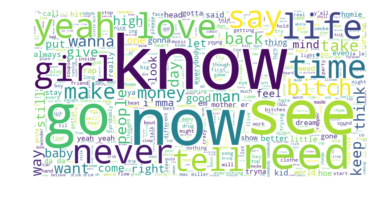

In [5]:
from os import path
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import os
from wordcloud import WordCloud, STOPWORDS

d = path.dirname(__file__) if "__file__" in locals() else os.getcwd()

# words to exclude from cloud -- don't add any meaning
stopwords = set(STOPWORDS)
stop_adds = ['got', 'aint', 'im', 'cause', 'don\'t', 'ain\'t']
for word in stop_adds:
    stopwords.add(word)

# create high-res wordcloud with 500 most common words in dataset
wc = WordCloud(background_color="white", max_words=500,
               stopwords=stopwords, width=800, height=400)
wc.generate(lyric_text)
wc.to_file(path.join(d, 'mac_wordcloud.png'))

# plot cloud
plt.imshow(wc, interpolation='bilinear')
plt.axis("off")
plt.figure(figsize=(20, 10))
plt.show()

### Markov chain builder

In [6]:
# set default values for custom song generation (can be altered at function calls)
LINE_LENGTH = 8
STANZA_LENGTH = 4
STANZA_COUNT = 6

In [7]:
import random


def generate_line(lyric_text, line_length=LINE_LENGTH):
    words = lyric_text.split()  # separate lyrics into list of words
    index = 2  # initialize index count for markov chain of order 2
    chain = {}  # initialize dictionary of lyrics
    gen_length = line_length  # word count of output

    for word in words[index:len(words)-1]:
        key = str(words[index - 2] + ' ' + words[index - 1])
        if key in chain:  # check if word is already in dictionary
            chain[key].append(str(word + ' ' + words[index + 1]))
        else:
            chain[key] = [str(word + ' ' + words[index + 1])]
        index += 1

    words1 = random.choice(list(chain.keys()))
    new_lyric = words1.capitalize()

    while len(new_lyric.split(' ')) < gen_length:
        words2 = random.choice(chain[words1])
        words1 = words2
        new_lyric += ' ' + words2

    return new_lyric

In [8]:
def generate_song(lyrics, line_length=LINE_LENGTH, stanza_length=STANZA_LENGTH, stanzas=STANZA_COUNT):
    song = ''
    for stanza in range(stanzas):  # generate desired number of stanzas per song
        paragraph_split = generate_line(lyrics, line_length=(
            line_length * stanza_length)).split(' ')  # generate list of words for a stanza
        i = line_length
        while i <= len(paragraph_split):  # insert newlines after each line in the stanza
            paragraph_split.insert(i, '\n')
            i += line_length + 1
        # append each stanza onto the song
        song += ' '.join(paragraph_split) + '\n'
    return song

In [11]:
def write_song(lyric_text, to_txt=True):
    new_song = generate_song(lyric_text)
    if to_txt:
        with open('new_song.txt', 'w') as f:
            f.write(new_song)
    print(new_song)

In [12]:
write_song(lyric_text, True)

Fairy tale got some extra that's a blessing 
 roll me something to match baby you could 
 come a little closer, baby, don't be scared 
 now you laying on the floor is i 

Forgot our roots before and trust me, things 
 they fell apart wash myself with acid, it's 
 because i just dreamed of this land oh 
 oh, why don't you know that i’m pointing 

Ass drinking wine by the glass if we 
 gotta fight, i'll be down for butt$@!, it 
 will be the kid is nice, but i 
 know as time goes by, baby all i'm 

Close but they don't fit a long journey 
 to the sunrise but then i don't have 
 to cry you the seahawks this weed i 
 keep hittin' makin' me cough the olly giant, 

The sunshine all in the rearview let's leave 
 it all depends on dollars spent and knowledge 
 gained darkness on the phone i'm fighting with 
 the navy battle to the top now baby 

Rappin' everybody curious then you make out?" pretty 
 good, got a mansion then get my parents 
 still thought i was flippin' through channels on 
 the